In [1]:
import torch as t
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import math
from IPython.display import clear_output
from torch.autograd import Variable
import json
from sklearn.utils import shuffle

In [2]:
def plotRandom(train_index, train_images, train_data, lstm_in, nn_out, out_dict):
    
    """
    Plot a random element from the dataset.

    The function selects a random element from the given dataset and prints 
    all available information.

    Parameters
    ----------
    train_images : h5py
        image dataset
    train_data : pandas
        train dataset
    lstm_in : numpy.ndarray
        feature data used for input to NN
    nn_out : numpy.ndarray
        targets for the NN output
    out_dict : dict
        dictionary encoding the targets from index to word
        

    Returns
    -------
    int
        the index of the random element

    """

    idx = np.random.randint(0, len(train_images))
    
    print("=> ORIGINAL")
    print(train_data["index"].values[idx])
    print(train_data["question"].values[idx])
    print(train_data["encoding"].values[idx])
    print(train_data["answer"].values[idx])
    print(train_data["type"].values[idx])
    
    print("\n=> CONVERTED")
    print(lstm_in[idx])
    print(nn_out[idx])
    print(nn_out[idx], out_dict[nn_out[idx]])
    plt.imshow(train_images[train_index[idx]] / 255)
    plt.show()
    
    return idx

In [3]:
def loadData(file_name):
    
    """
    Load the data by a given file name. 

    Data comes in pairs of CSV and H5PY files. For the training of the
    model, we'll need both files per set.

    Parameters
    ----------
    file_name : string
        the name of the data pair to load
        

    Returns
    -------
    h5py array
        the h5py array to prevent loading all the images to RAM
    pandas dataframe
        the training data for each image (more information here: https://www.kaggle.com/gruberpatrick/sortofclevr)

    """
    
    # load the data;
    train_images = h5py.File("./sort-of-clevr/"+file_name+".h5")[file_name]
    train_data = pd.read_csv("./sort-of-clevr/"+file_name+".csv")

    # show the shapes;
    print(train_images.shape, train_data["index"].values.shape)
    
    return train_images, train_data

In [4]:
def loadQuestionEncoding(train_images, train_data):
    
    """
    Load JSON encoded catgorical question encoding.
    
    Since the categorical encoding is JSON encoded, we'll have to
    decode the information before we can use it.

    Parameters
    ----------
    file_name : string
        the name of the data pair to load
        

    Returns
    -------
    numpy.ndarray
        the simulated outputs of the LSTM
    numpy.ndarray
        each image is assigned whether it is used as a relational or non-relational example

    """
    
    print("Loading question encoding.")
    
    # load the encoding;
    count = 0
    lstm_in = []
    train_index = []
    for it in range(len(train_data["encoding"].values)): 
        enc = json.loads(train_data["encoding"].values[it])
        #if enc[8] == 1: count += 1
        #if count >= 22000: continue
        lstm_in.append(enc)
        train_index.append(it)
    
    return np.array(train_index), np.array(lstm_in)

In [5]:
train_images, train_data = loadData("data_train")
train_index, lstm_in = loadQuestionEncoding(train_images, train_data)
print(lstm_in.shape)

(70000, 128, 128, 3) (70000,)
Loading question encoding.
(70000, 10)


In [6]:
val_train_images, val_train_data = loadData("data_val")
_, val_lstm_in = loadQuestionEncoding(val_train_images, val_train_data)
print(val_lstm_in.shape)

(10000, 128, 128, 3) (10000,)
Loading question encoding.
(10000, 10)


In [7]:
def getOutputs(train_data, lstm_in, nrout_tokenizer=None):
    
    """
    Encode the targets.

    We'll use a categorical representation to train the network. For this
    we need to take the current word answers, assign them indexes and
    encode the output. Previously we assigned the image a representation,
    which means that a question input is either relational or non-relational.
    Here we also load the correct relational or non-relational answer.

    Parameters
    ----------
    train_data : pandas
        train dataset
    lstm_in : numpy.ndarray
        feature data used for input to NN
    dist_encoding : numpy.ndarray
        the assignment of the dataset (relational or non-relational)
    nrout_tokenizer : dict
        the word encoding (given that we want to use the same encoding for validation and test)
        if not given, a new dict is created
        

    Returns
    -------
    numpy.ndarray
        the categorically encoded targets
    dict
        index to word dictionary
    dict
        word to index dictionary

    """
    
    nn_full = []
    for it in range(lstm_in.shape[0]): 
        nn_full.append(train_data["answer"][it])
    
    # combine the data and tokenize the input;
    highest = 16
    if not nrout_tokenizer:
        
        word_index = {}
        index_word = {}
        idx = 0
        for it in range(len(nn_full)):
            if nn_full[it] not in word_index:
                word_index[nn_full[it]] = idx
                index_word[idx] = nn_full[it]
                idx += 1
                
    else:
        
        word_index = nrout_tokenizer
        index_word = {}
        for it in word_index:
            index_word[word_index[it]] = it
        
    nn_out = []
    for it in range(len(nn_full)):
        nn_out.append(word_index[nn_full[it]])
    nn_out = np.array(nn_out)
        
    return nn_out, index_word, word_index

In [8]:
nn_out, train_dict, nrout_tokenizer = getOutputs(train_data, lstm_in)
print(nn_out.shape)
print(train_dict)

(70000,)
{0: 'right', 1: 'blue', 2: 'circle', 3: 'left', 4: 'bottom', 5: 'yellow', 6: 'square', 7: 'green', 8: 'red', 9: 'top', 10: 'gray'}


In [9]:
val_nn_out, val_dict, nrout_tokenizer = getOutputs(val_train_data, val_lstm_in, nrout_tokenizer)
print(val_nn_out.shape)
print(val_dict)

(10000,)
{0: 'right', 1: 'blue', 2: 'circle', 3: 'left', 4: 'bottom', 5: 'yellow', 6: 'square', 7: 'green', 8: 'red', 9: 'top', 10: 'gray'}


=> ORIGINAL
49815
What is the color of the object that is closest to the blue object?
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
gray
0

=> CONVERTED
[0 0 0 1 0 0 0 0 0 1]
10
10 gray


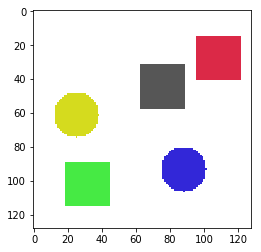

49815

In [10]:
plotRandom(train_index, train_images, train_data, lstm_in, nn_out, val_dict)

# Relation Network

In [47]:
class RelationNetwork(t.nn.Module):
    
    # -----------------------------------------------------------
    def __init__(self, out_size=16, batch_size=128, img_size=5):
        
        self._step = 0
        
        super(RelationNetwork, self).__init__()
        self._conv1 = t.nn.Conv2d(3, 24, 3, stride=2, padding=1).cuda()
        self._conv2 = t.nn.Conv2d(24, 24, 3, stride=2, padding=1).cuda()
        self._conv3 = t.nn.Conv2d(24, 24, 3, stride=2, padding=1).cuda()
        self._conv4 = t.nn.Conv2d(24, 24, 3, stride=2, padding=1).cuda()
        self._conv5 = t.nn.Conv2d(24, 24, 3, stride=2, padding=2).cuda()
        self._batch_norm1 = t.nn.BatchNorm2d(24).cuda()
        self._batch_norm2 = t.nn.BatchNorm2d(24).cuda()
        self._batch_norm3 = t.nn.BatchNorm2d(24).cuda()
        self._batch_norm4 = t.nn.BatchNorm2d(24).cuda()
        self._batch_norm5 = t.nn.BatchNorm2d(24).cuda()
        self._g1 = t.nn.Linear(62, 256).cuda()
        self._g2 = t.nn.Linear(256, 256).cuda()
        self._g3 = t.nn.Linear(256, 256).cuda()
        self._g4 = t.nn.Linear(256, 256).cuda()
        self._g5 = t.nn.Linear(256, 256).cuda()
        self._g6 = t.nn.Linear(256, 256).cuda()
        self._relu = t.nn.ReLU().cuda()
        self._dropout = t.nn.Dropout(.5).cuda()
        self._f1 = t.nn.Linear(256, 256).cuda()
        self._f2 = t.nn.Linear(256, 256).cuda()
        self._f3 = t.nn.Linear(256, 256).cuda()
        self._f4 = t.nn.Linear(256, 256).cuda()
        self._f5 = t.nn.Linear(256, 29).cuda()
        self._f_out = t.nn.Linear(29, out_size).cuda()
        
        self._tags, self._locations = self.tagging(img_size, batch_size)
        
    # -----------------------------------------------------------
    def tagging(self, img_size, batch_size):
        
        locations = []
        tags = []
        for x in range(img_size):
            row = []
            for y in range(img_size): row.append([x, y])
            tags.extend(row)
            locations.extend(row)
        tags = np.array(tags)
        X = t.from_numpy((2 * tags / (img_size-1)) - 1).float().cuda()
        print(X.size())
        size = X.size()
        return X.expand(batch_size, size[0], size[1]), locations
    
    # -----------------------------------------------------------
    def g(self, X):
        
        X = self._g1(X)
        X = self._relu(X)
        X = self._g2(X)
        X = self._relu(X)
        X = self._g3(X)
        X = self._relu(X)
        X = self._g4(X)
        #X = self._relu(X)
        #X = self._g5(X)
        #X = self._relu(X)
        #X = self._g6(X)
        return self._relu(X)
        
    # -----------------------------------------------------------
    def f(self, X):
        
        X = self._f1(X)
        X = self._relu(X)
        X = self._f2(X)
        X = self._relu(X)
        X = self._dropout(X)
        X = self._f3(X)
        X = self._relu(X)
        X = self._f4(X)
        X = self._relu(X)
        X = self._f5(X)
        X = self._relu(X)
        X = self._f_out(X)
        return t.nn.functional.log_softmax(X, dim=1)
        #return X
        
    # -----------------------------------------------------------
    def forward(self, imgs, questions, debug=False):
        
        # convolutional model;
        if debug: print("CONV_IN", imgs.size())
        X = self._conv1(imgs)
        X = self._relu(X)
        X = self._batch_norm1(X)
        X = self._conv2(X)
        X = self._relu(X)
        X = self._batch_norm2(X)
        X = self._conv3(X)
        X = self._relu(X)
        X = self._batch_norm3(X)
        X = self._conv4(X)
        X = self._relu(X)
        X = self._batch_norm4(X)
        X = self._conv5(X)
        X = self._relu(X)
        X = self._batch_norm5(X)
        if debug: print("CONV_OUT", X.size())
        
        #tagging;
        X_size = X.size()
        tags, locations = self._tags, self._locations
        if debug: print("TAGS", tags.size())
        #print(X_size)
        X = X.view(64, 24, 5*5).permute(0, 2, 1)
        X = t.cat([X, tags],2)
        #X = t.cat([X, tags], dim=1)
        if debug: print("TAGGED", X.size())
        
        # slice and run g();
        g_all = []
        
        for obj1 in range(5*5):
            for obj2 in range(5*5):
                if debug: print("\rSLICES", obj1, obj2, end="")
                g_in = t.cat([ X[:,obj1,:], X[:,obj2,:], questions ], dim=1)
                g_all.append( self.g(g_in) )
        
        """for obj1 in locations:
            for obj2 in locations:
                if debug: print("\rSLICES", obj1, obj2, end="")
                g_in = t.cat([ X[:,:,obj1[0],obj1[1]], X[:,:,obj2[0],obj2[1]], questions ], dim=1)
                g_all.append( self.g(g_in) )"""
                
        print("")
        # sum g() outputs;
        X = t.stack(g_all, dim=1)
        if debug: print("PRE_SUM", X.size())
        X = t.mean(X, 1)
        if debug: print("POST_SUM", X.size())
        
        # run f()
        X = self.f(X)
        if debug: print("f()", X.size())
        
        return X
    
    # -----------------------------------------------------------
    def loss(self, outputs, targets):
        
        return self._loss(outputs, targets)
        
    # -----------------------------------------------------------
    def optimizer(self):
        
        self._optimizer = t.optim.Adam(self.parameters(), lr=self._lr)
        
    # -----------------------------------------------------------
    def prepTraining(self, lr=.001, decay_rate=.5, decay_steps=10000):
        
        self._lr = lr
        self._decay_rate = decay_rate
        self._decay_steps = decay_steps
        self.optimizer()
        self._loss = t.nn.NLLLoss()
        #self._loss = t.nn.CrossEntropyLoss()
        
    # -----------------------------------------------------------
    def exponentialDecay(self):
        
        lr = self._lr * pow(self._decay_rate, self._step / self._decay_steps)
        for param_group in self._optimizer.param_groups:
            param_group["lr"] = lr
        
    # -----------------------------------------------------------
    def train(self, imgs, questions, answers, decay=True):
        
        # training step;
        outputs = self(imgs, questions)
        loss = self.loss(outputs, answers)
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        # calculate accuracy;
        pred = outputs.data.max(1)[1]
        correct = pred.eq(answers.data).float().cpu().sum()
        accuracy = correct / len(answers)
        
        # decay;
        self._step += 1
        if decay: self.exponentialDecay()
        
        return loss.item(), accuracy.item()

    # -----------------------------------------------------------
    def test(self, imgs, questions, answers):
        
        # calculate loss;
        outputs = self(imgs, questions)
        loss = self.loss(outputs, answers)
        
        # calculate accuracy;
        pred = outputs.data.max(1)[1]
        correct = pred.eq(answers.data).float().cpu().sum()
        accuracy = correct / len(answers)

        return loss.item(), accuracy.item()
    
    # -----------------------------------------------------------
    def predict(self, imgs, questions, debug=False):
        
        return self(imgs, questions, debug=debug)
        
    # -----------------------------------------------------------
    def initializeWeights(self):
        
        t.nn.init.xavier_uniform_(self._conv1.weight),
        t.nn.init.xavier_uniform_(self._conv2.weight),
        t.nn.init.xavier_uniform_(self._conv3.weight),
        t.nn.init.xavier_uniform_(self._conv4.weight),
        t.nn.init.xavier_uniform_(self._conv5.weight),
        t.nn.init.xavier_uniform_(self._g1.weight),
        t.nn.init.xavier_uniform_(self._g2.weight),
        t.nn.init.xavier_uniform_(self._g3.weight),
        t.nn.init.xavier_uniform_(self._g4.weight),
        t.nn.init.xavier_uniform_(self._g5.weight),
        t.nn.init.xavier_uniform_(self._g6.weight),
        t.nn.init.xavier_uniform_(self._f1.weight),
        t.nn.init.xavier_uniform_(self._f2.weight),
        t.nn.init.xavier_uniform_(self._f3.weight),
        t.nn.init.xavier_uniform_(self._f4.weight),
        t.nn.init.xavier_uniform_(self._f5.weight),
        t.nn.init.xavier_uniform_(self._f_out.weight)
        

In [57]:
batch_size = 64
lr = 2.5e-4
decay_steps = 3120
decay_rate = 0.5
epochs = 50

In [49]:
rn = RelationNetwork(out_size=11, batch_size=batch_size)
rn = rn.cuda()
rn.prepTraining(lr=lr, decay_rate=decay_rate, decay_steps=decay_steps)
rn.initializeWeights()

torch.Size([25, 2])


In [50]:
y = rn.predict(
    t.randn(batch_size,3,128,128).float().cuda(),
    t.randn(batch_size,10).float().cuda(),
    debug=True
)

CONV_IN torch.Size([64, 3, 128, 128])
CONV_OUT torch.Size([64, 24, 5, 5])
TAGS torch.Size([64, 25, 2])
TAGGED torch.Size([64, 25, 26])
SLICES 24 24
PRE_SUM torch.Size([64, 625, 256])
POST_SUM torch.Size([64, 256])
f() torch.Size([64, 11])


In [51]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []
model_time = str(int(time()))

In [52]:
stop = True
try: thr.join()
except: print("Thread not started...")
queue = []
stop = False
def queueBatch(train_index, images, lstm, out, batch_size=64, total=1):
    global queue
    amount = math.floor(lstm.shape[0] / batch_size)
    #amount = 157
    #amount = 10
    batches = list(range(amount))
    train_index, lstm, out = shuffle(train_index, lstm, out)
    while True:
        np.random.shuffle(batches)
        c = 0
        for it in batches:
            if stop: return True
            while len(queue) >= 10:
                if stop: return True
                sleep(1)
            imgs = []
            for jt in range((it)*batch_size, (it+1)*batch_size):
                imgs.append(images[train_index[jt]] / 255)
            imgs = np.array(imgs)
            #print(np.moveaxis(imgs, 3, 1).shape)
            data = [
                t.from_numpy(np.moveaxis(imgs, 3, 1)).float().cuda(),
                t.from_numpy(lstm[(it)*batch_size:(it+1)*batch_size]).float().cuda(),
                t.from_numpy(out[(it)*batch_size:(it+1)*batch_size]).long().cuda()
            ]
            
            c += 1
            queue.append((data[0], data[1], data[2], c, amount))
import threading
from time import sleep
thr = threading.Thread(target=queueBatch, args=(train_index, train_images, lstm_in, nn_out, batch_size, 0))
thr.start()

In [53]:
def getBatch(images, lstm, out, batch_size=64, total=1):
    amount = math.floor(lstm.shape[0] / batch_size)
    batches = list(range(amount))
    np.random.shuffle(batches)
    c = 0
    for it in batches:
        imgs = []
        for jt in range((it)*batch_size, (it+1)*batch_size):
            imgs.append(images[train_index[jt]] / 255)
        imgs = np.array(imgs)
        data = [
            t.from_numpy(np.moveaxis(imgs, 3, 1)).float().cuda(),
            t.from_numpy(lstm[(it)*batch_size:(it+1)*batch_size]).float().cuda(),
            t.from_numpy(out[(it)*batch_size:(it+1)*batch_size]).long().cuda()
        ]
        c += 1
        yield (data[0], data[1], data[2], c, amount)

In [55]:
print(len(queue))

2


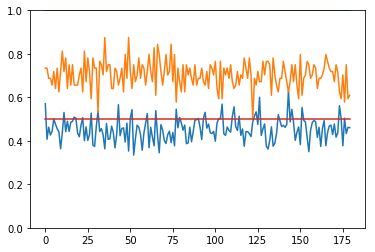

# EPOCH 15 / 50 [ 180 / 1093 ] Loss: 0.4605939984321594  || Accuracy: 0.609375

# EPOCH 15 / 50 [ 181 / 1093 ] Loss: 0.4034155607223511  || Accuracy: 0.734375

# EPOCH 15 / 50 [ 182 / 1093 ] Loss: 0.48894262313842773  || Accuracy: 0.65625

# EPOCH 15 / 50 [ 183 / 1093 ] Loss: 0.4981045722961426  || Accuracy: 0.78125

# EPOCH 15 / 50 [ 184 / 1093 ] Loss: 0.4142833948135376  || Accuracy: 0.765625

# EPOCH 15 / 50 [ 185 / 1093 ] Loss: 0.5016788840293884  || Accuracy: 0.65625

# EPOCH 15 / 50 [ 186 / 1093 ] Loss: 0.4826604723930359  || Accuracy: 0.6875

# EPOCH 15 / 50 [ 187 / 1093 ] Loss: 0.45866331458091736  || Accuracy: 0.765625

# EPOCH 15 / 50 [ 188 / 1093 ] Loss: 0.4202791154384613  || Accuracy: 0.6875

# EPOCH 15 / 50 [ 189 / 1093 ] Loss: 0.5265445709228516  || Accuracy: 0.65625



KeyboardInterrupt: 

In [58]:
# run epochs;
for epoch in range(epochs):

    print("# EPOCH", str(epoch + 1), "/", str(epochs), "====================================")
    epoch_losses = []
    epoch_acc = []
    totals = 1
    currents = 0

    # run mini-batches;
    while currents < totals:

        while len(queue) <= 0: sleep(2)

        images, lstms, targets, current, total = queue.pop(0)
        totals = total
        currents = current
        
        loss, acc = rn.train(images, lstms, targets, decay=False)
        
        epoch_losses.append(loss)
        epoch_acc.append(acc)
        
        if currents % 10 == 0:
            clear_output()
            plt.ylim((0, max(1, np.max(epoch_losses))))
            plt.plot([it for it in range(len(epoch_losses))], epoch_losses)
            plt.plot([it for it in range(len(epoch_acc))], epoch_acc)
            plt.plot([0, len(epoch_losses)-1], [1, 1])
            plt.plot([0, len(epoch_losses)-1], [.5, .5])
            plt.show()
            
        print("# EPOCH "+str(epoch+1)+" / "+str(epochs)+" [", current, "/", total,"] Loss:", loss, " || Accuracy:", acc)
        
    losses.append(np.mean(epoch_losses))
    accuracies.append(np.mean(epoch_acc))
    print("\r[", current, "/", total,"] Complete - Loss:", np.mean(epoch_losses), "|| Accuracy:", np.mean(epoch_acc), "                               ")
    
    plt.ylim((0, max(1, np.max(losses))))
    plt.plot([it for it in range(len(losses))], losses)
    plt.plot([it for it in range(len(accuracies))], accuracies)
    plt.plot([0, len(losses)-1], [1, 1])
    plt.plot([0, len(losses)-1], [.5, .5])
    plt.show()
    
    rval = {"acc":[], "loss":[]}
    for batch in getBatch(val_train_images, val_lstm_in, val_nn_out, batch_size=batch_size, total=2):
        images, lstms, targets, current, total = batch
        loss, acc = rn.test(images, lstms, targets)
        rval["acc"].append(acc)
        rval["loss"].append(loss)
        print("\r[ validation ]", current/total*100, "%", end="")
    print("\r[ validation ]","Loss:",np.mean(rval["loss"]),"|| Accuracy:",np.mean(rval["acc"]))
    val_losses.append(np.mean(rval["loss"]))
    val_accuracies.append(np.mean(rval["acc"]))
    
    t.save(rn, "./model.ckpt")
    

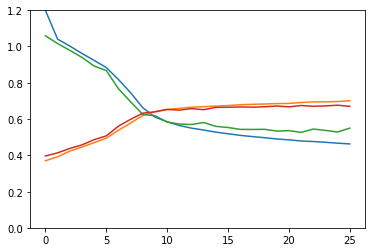

In [61]:
plt.ylim((0, max(1, np.max(losses))))
plt.plot([it for it in range(len(losses))], losses)
plt.plot([it for it in range(len(accuracies))], accuracies)
plt.plot([it for it in range(len(val_losses))], val_losses)
plt.plot([it for it in range(len(val_accuracies))], val_accuracies)
#plt.plot([0, len(losses)-1], [1, 1])
#plt.plot([0, len(losses)-1], [.5, .5])
plt.show()